In [1]:
!pip install transformers accelerate sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, json, re

model_id = "Qwen/Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_qwen = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
def qwen_generate(prompt, max_tokens=512):
    """Sinh văn bản bằng Qwen (Instruct)."""

    text = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(text, return_tensors="pt").to(model_qwen.device)

    output = model_qwen.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=0.7,
        top_p=0.9,
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
import re

def clean_output(raw):
    # Xóa các ký tự lạ ngoài ASCII + tiếng Việt
    raw = re.sub(r"[^\x00-\x7FÀ-ỹ\s.,!?\"'“”‘’\-:/()]", "", raw)
    # Xóa bớt khoảng trắng dư
    raw = re.sub(r"\s+", " ", raw)
    return raw.strip()

In [ ]:
import json, re

def generate_dpo_batch(batch_size=20):
    prompt = f"""
Generate {batch_size} SIMPLE DPO samples for English→Vietnamese translation.

Each sample must be ONE JSON object with EXACTLY these keys:
{{
  "prompt": "<simple English sentence>",
  "chosen": "<correct Vietnamese translation>",
  "rejected": "<slightly incorrect Vietnamese translation>"
}}

### RULES ###
- English sentences MUST be SIMPLE:
- English sentence MUST BE 8–25 words.
- Vietnamese sentence MUST BE 8–25 words.
- Diverse topics: daily life, education, technology, science, society.
- "chosen" MUST be a 100% faithful and literal translation.
- "rejected" must contain a small mistake (wrong word, missing word, extra word).
- "rejected" MUST NOT be identical to "chosen".
- NO explanation. NO numbering. NO extra text.

### OUTPUT FORMAT ###
(Repeat EXACTLY {batch_size} JSON objects, one after another)

Begin output NOW:
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    raw = clean_output(raw)

    idx = raw.lower().rfind("assistant")
    if idx != -1:
        raw = raw[idx + len("assistant"):].strip()

    json_blocks = re.findall(r"\{.*?\}", raw)

    results = []
    for block in json_blocks:
        try:
            data = json.loads(block)
            if (
                isinstance(data.get("prompt"), str) and
                isinstance(data.get("chosen"), str) and
                isinstance(data.get("rejected"), str)
            ):
                results.append(data)
        except:
            continue

    if not results:
        print("Không parse được JSON nào!\nRaw:\n", raw)

    return results


In [ ]:
def generate_dpo_bulk(total=200, batch=20):
    all_results = []
    loops = total // batch

    for i in range(loops):
        print(f"[DPO] Batch {i+1}/{loops} ...")
        part = generate_dpo_batch(batch_size=batch)
        all_results.extend(part)

    remain = total % batch
    if remain > 0:
        print(f"[DPO] Last batch: {remain} ...")
        part = generate_dpo_batch(batch_size=remain)
        all_results.extend(part)

    return all_results

In [ ]:
dpo_result = generate_dpo_bulk(total=500, batch=20)
print("Tổng số mẫu DPO:", len(dpo_result))

In [ ]:
# In 10 dòng đầu tiên trong dataset DPO
for item in dpo_result[:10]:
    print({
        "prompt": item["prompt"],
        "chosen": item["chosen"],
        "rejected": item["rejected"]
    })
    print()  # dòng trống cho dễ nhìn

In [ ]:
save_path = "dpo_dataset.jsonl"

with open(save_path, "w", encoding="utf-8") as f:
    for item in dpo_result:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print("Đã lưu file:", save_path)

Chạy lại model SFT

In [ ]:
!pip install transformers accelerate sentencepiece -q

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
import torch

# ============================================================
# LOAD DỮ LIỆU SONG NGỮ
# ============================================================
dataset = load_dataset(
    "harouzie/vi_en-translation",
    split="train",
    token=""
).shuffle(seed=42).select(range(5000))

# ============================================================
# CHIA TẬP TRAIN / TEST
# ============================================================
split_ds = dataset.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = split_ds["train"], split_ds["test"]

2025-11-16 10:33:32.566651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763289212.754566      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763289212.806858      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

data/train-00000-of-00001-8fc21cb8e80d3a(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/test-00000-of-00001-858c0e989d9c563(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

data/valid-00000-of-00001-99e7e50144d1c1(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

In [3]:
print(train_ds)
print(eval_ds)
# ============================================================
print("\nDữ liệu trong tập train:")
for i in range(3):
    print(f"\nEnglish: {train_ds[i]['English']}")
    print(f"Vietnamese: {train_ds[i]['Vietnamese']}")

Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 4500
})
Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 500
})

Dữ liệu trong tập train:

English: Is there a tennis court around here?
Vietnamese: Có một sân tennis quanh đây không?

English: I want you to promise me something.
Vietnamese: tôi muốn bạn hứa với tôi một cái gì đó

English: Thank you for your kind assistance.
Vietnamese: cảm ơn sự giúp đỡ của bạn


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/kaggle/input/mt5-envit5-style/mt5_envit5_style"

# Load model và tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float32   # hoặc bfloat16 nếu GPU hỗ trợ
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("Model và tokenizer đã được load thành công!")

In [ ]:
def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            early_stopping=True
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Test
test_sentences = [
    "She is my best friend.",
    "The weather is nice today.",
    "Can you help me?",
    "Please open the door.",
    "He didn’t come yesterday.",
    "They are playing football.",
    "It’s time to go home."
]

for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")

DPO

In [19]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.3 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch, json, re
import torch.nn.functional as F
from torch.optim import AdamW

device = "cuda"

# model SFT dùng để train DPO
model = AutoModelForSeq2SeqLM.from_pretrained(
    "/kaggle/input/mt5-envit5-style/mt5_envit5_style",
    torch_dtype=torch.bfloat16
).to(device)

# model tham chiếu
model_ref = AutoModelForSeq2SeqLM.from_pretrained(
    "/kaggle/input/mt5-envit5-style/mt5_envit5_style",
    torch_dtype=torch.bfloat16
).to(device)
model_ref.eval()
for p in model_ref.parameters():
    p.requires_grad = False


tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/mt5-envit5-style/mt5_envit5_style")
MAX_LENGTH = 128

In [5]:
def compute_logprob(model, tokenizer, x, y):
    # Encode input
    inputs = tokenizer(x, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(y, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).input_ids.to(device)
    # Forward
    out = model(**inputs, labels=labels)
    # log-softmax over vocab
    log_probs = out.logits.log_softmax(-1)
    # Lấy log-prob token đúng: gather theo labels
    token_logprobs = torch.gather(log_probs, 2, labels.unsqueeze(-1)).squeeze(-1)
    # Padding có label = -100, bỏ đi
    mask = (labels != -100).float()
     # log-prob normalized theo số token
    return (token_logprobs * mask).sum() / mask.sum()


In [6]:
def dpo_loss(model, model_ref, tokenizer, x, chosen, rejected, beta=0.1):
    model.train()
    # Log-probability: p_theta(chosen | x)
    log_p_w = compute_logprob(model, tokenizer, x, chosen)
     # Log-probability: p_theta(rejected | x)
    log_p_l = compute_logprob(model, tokenizer, x, rejected)
    # Đánh giá log-probability dựa trên model tham chiếu (fixed)
    with torch.no_grad():
        log_ref_w = compute_logprob(model_ref, tokenizer, x, chosen)
        log_ref_l = compute_logprob(model_ref, tokenizer, x, rejected)

    z = beta * ((log_p_w - log_ref_w) - (log_p_l - log_ref_l))
    # Loss DPO: -log(sigmoid(z))
    loss = -F.logsigmoid(z)
    return loss


In [7]:
import json

data = []

with open("/kaggle/input/dpo-datasetv5-jsonl/dpo_datasetV5.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # bỏ dòng trống
        try:
            obj = json.loads(line)
            data.append(obj)
        except json.JSONDecodeError:
            print("Dòng lỗi JSON:", line)
            continue
print("Tổng số mẫu:", len(data))

Tổng số mẫu: 2000


In [8]:
for i, item in enumerate(data[:5], 1):
    print(f"\n--- SAMPLE {i} ---")
    print("prompt:  ", item.get("prompt"))
    print("chosen:  ", item.get("chosen"))
    print("rejected:", item.get("rejected"))


--- SAMPLE 1 ---
prompt:   I love reading books.
chosen:   Tôi yêu thích đọc sách.
rejected: Tôi thích đọc sách và viết.

--- SAMPLE 2 ---
prompt:   The cat is sleeping on the sofa.
chosen:   Con mèo đang ngủ trên ghế sofa.
rejected: Chú mèo đang nằm trên chiếc sofa.

--- SAMPLE 3 ---
prompt:   She teaches English at a university.
chosen:    Cô ấy dạy tiếng Anh tại một trường đại học.
rejected: Cô ấy giảng dạy tiếng Anh trong một trường đại học.

--- SAMPLE 4 ---
prompt:   They built a new bridge last year.
chosen:   Họ đã xây dựng một cây cầu mới vào năm ngoái.
rejected: Họ đã xây dựng một cây cầu cũ vào năm qua.

--- SAMPLE 5 ---
prompt:   He studies computer science.
chosen:   Anh ấy học khoa học máy tính.
rejected: Anh ấy học khoa học máy tính và điện tử.


In [9]:
# Giả sử data đã được load sẵn từ file JSONL
# In ra 5 dòng cuối
for i, item in enumerate(data[-5:], len(data) - 4):
    print(f"\n--- SAMPLE {i} ---")
    print("prompt:  ", item.get("prompt"))
    print("chosen:  ", item.get("chosen"))
    print("rejected:", item.get("rejected"))



--- SAMPLE 1996 ---
prompt:   She organized a virtual reunion with her college friends.
chosen:   Cô ấy đã tổ chức một buổi họp mặt trực tuyến với bạn đại học.
rejected: Cô ấy tán gẫu với robot và gọi đó là họp lớp.

--- SAMPLE 1997 ---
prompt:   He delivered the package to the wrong address.
chosen:   Anh ấy đã giao nhầm địa chỉ.
rejected: Anh ấy giữ gói hàng làm của riêng và gọi đó là tái chế vật phẩm.

--- SAMPLE 1998 ---
prompt:   She wore a helmet while riding her bike.
chosen:   Cô ấy đã đội mũ bảo hiểm khi đạp xe.
rejected: Cô ấy đội mũ bơi khi đạp xe để chống mưa.

--- SAMPLE 1999 ---
prompt:   He folded the laundry and put it away.
chosen:   Anh ấy đã gấp quần áo và cất đi.
rejected: Anh ấy gấp quần áo thành hình con thỏ rồi trang trí phòng khách.

--- SAMPLE 2000 ---
prompt:   They replaced the old roof with solar shingles.
chosen:   Họ đã thay mái nhà cũ bằng mái năng lượng mặt trời.
rejected: Họ sơn mái nhà thành màu xanh và gọi đó là năng lượng mới.


In [10]:
print("Dữ liệu mẫu đầu tiên:")
print(json.dumps(data[0], indent=2, ensure_ascii=False))

print("\nTổng dòng dữ liệu:", len(data))

# Kiểm tra tất cả dòng có 3 key
for i, item in enumerate(data):
    if not all(k in item for k in ["prompt", "chosen", "rejected"]):
        print(f"Dòng {i} bị lỗi:", item)


Dữ liệu mẫu đầu tiên:
{
  "prompt": "I love reading books.",
  "chosen": "Tôi yêu thích đọc sách.",
  "rejected": "Tôi thích đọc sách và viết."
}

Tổng dòng dữ liệu: 2000


In [11]:
# Chọn 1 mẫu bất kỳ
sample = data[0]
x = "translate English to Vietnamese: " + sample["prompt"]
chosen = sample["chosen"]
rejected = sample["rejected"]

# Tokenize
inputs = tokenizer(x, return_tensors="pt", max_length=128, truncation=True, padding=True)
with tokenizer.as_target_tokenizer():
    chosen_labels = tokenizer(chosen, return_tensors="pt", max_length=128, truncation=True, padding=True).input_ids
    rejected_labels = tokenizer(rejected, return_tensors="pt", max_length=128, truncation=True, padding=True).input_ids

print("\nTokenized prompt:", inputs["input_ids"][0][:20])
print("Tokenized chosen:", chosen_labels[0][:20])
print("Tokenized rejected:", rejected_labels[0][:20])



Tokenized prompt: tensor([ 37194,   5413,    288,    259, 134126,    267,    336,   3869,  11807,
         20743,    260,      1])
Tokenized chosen: tensor([ 366, 3571,  259, 3565,  273,  394, 2986,  355, 4929,  259,  263, 1833,
         260,    1])
Tokenized rejected: tensor([ 366, 3571,  394, 2986,  355, 4929,  259,  263, 1833,  259,  793,  300,
        2591,  260,    1])


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [12]:
log_p_chosen = compute_logprob(model, tokenizer, x, chosen)
log_p_rejected = compute_logprob(model, tokenizer, x, rejected)

print("\nlog_p_chosen =", log_p_chosen.item())
print("log_p_rejected =", log_p_rejected.item())


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.



log_p_chosen = -0.8322564959526062
log_p_rejected = -1.3593159914016724


In [13]:
# --------- Training ----------
from torch.nn.utils import clip_grad_norm_

optimizer = AdamW(model.parameters(), lr=2e-5)   # LR hợp lý cho DPO
BATCH = 4

steps = len(data) // BATCH

for step in range(steps):
    batch = data[step*BATCH : (step+1)*BATCH]

    model.train()
    optimizer.zero_grad()

    total_loss = 0

    for ex in batch:
        # PROMPT INSTRUCTION 
        x = "translate English to Vietnamese: " + ex["prompt"]

        loss = dpo_loss(model, model_ref, tokenizer, x, ex["chosen"], ex["rejected"])
        total_loss += loss

    # >>> CHIA LOSS CHO BATCH (bắt buộc) <<<
    total_loss = total_loss / BATCH

    # backward
    total_loss.backward()

    # >>> GRADIENT CLIPPING <<<
    clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    if step % 20 == 0:
        print(f"Step {step}/{steps} | Loss = {total_loss.item():.4f}")
ft

Step 0/500 | Loss = 0.7443
Step 20/500 | Loss = 0.7853
Step 40/500 | Loss = 0.8000
Step 60/500 | Loss = 0.7520
Step 80/500 | Loss = 0.7804
Step 100/500 | Loss = 0.6884
Step 120/500 | Loss = 0.7769
Step 140/500 | Loss = 0.8192
Step 160/500 | Loss = 0.7800
Step 180/500 | Loss = 0.7528
Step 200/500 | Loss = 0.7377
Step 220/500 | Loss = 0.7657
Step 240/500 | Loss = 0.8349
Step 260/500 | Loss = 0.7712
Step 280/500 | Loss = 0.7668
Step 300/500 | Loss = 0.7875
Step 320/500 | Loss = 0.8227
Step 340/500 | Loss = 0.8362
Step 360/500 | Loss = 0.8104
Step 380/500 | Loss = 0.7706
Step 400/500 | Loss = 0.8302
Step 420/500 | Loss = 0.7577
Step 440/500 | Loss = 0.8521
Step 460/500 | Loss = 0.8571
Step 480/500 | Loss = 0.8507


In [14]:
model.save_pretrained("./mt5_envit5_dpo/")
tokenizer.save_pretrained("./mt5_envit5_dpo/")

('./mt5_envit5_dpo/tokenizer_config.json',
 './mt5_envit5_dpo/special_tokens_map.json',
 './mt5_envit5_dpo/spiece.model',
 './mt5_envit5_dpo/added_tokens.json',
 './mt5_envit5_dpo/tokenizer.json')

In [49]:
import shutil

# Đường dẫn thư mục và file zip
folder_path = "./mt5_envit5_dpo"
zip_path = "./mt5_envit5_dpo.zip"

# Nén thành ZIP
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print("Đã nén thành công:", zip_path)

Đã nén thành công: ./mt5_envit5_dpo.zip


In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "./mt5_envit5_dpo/"

# Load model và tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16   
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("Model và tokenizer đã được load thành công!")

Model và tokenizer đã được load thành công!


In [16]:
def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            early_stopping=True
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [17]:
# Test
test_sentences = [
    "She is my best friend.",
    "The weather is nice today.",
    "Can you help me?",
    "Please open the door.",
    "He didn’t come yesterday.",
    "They are playing football.",
    "It’s time to go home."
]

for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")


English: She is my best friend.
Vietnamese: cô ấy là bạn bè của tôi.

English: The weather is nice today.
Vietnamese: hôm nay thời tiết tuyệt

English: Can you help me?
Vietnamese: bạn có thể giúp tôi không?

English: Please open the door.
Vietnamese: vui lòng mở cửa.

English: He didn’t come yesterday.
Vietnamese: anh ấy đã không đến hôm qua.

English: They are playing football.
Vietnamese: họ đang chơi bóng đá.

English: It’s time to go home.
Vietnamese: đã đến lúc về nhà.


In [ ]:
from datasets import load_dataset
import json

# ============================================================
# Load & shuffle dataset giống hệt SFT (seed=42)
# ============================================================
print("Đang tải dữ liệu gốc...")
full_ds = load_dataset(
    "harouzie/vi_en-translation",
    split="train",
    token=""
).shuffle(seed=42)
print("Tổng số mẫu:", len(full_ds))

# ============================================================
# 1k câu cho test
# ============================================================
test_ds = full_ds.select(range(7000, 8000))  # 1000 mẫu Test
print("Tổng số mẫu test:", len(test_ds))

Đang tải dữ liệu gốc...
Tổng số mẫu: 203272
Tổng số mẫu test: 1000


In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import sacrebleu
import json

# ============================================================
# HÀM DỊCH & ĐÁNH GIÁ BLEU
# ============================================================
def translate_batch(model, tokenizer, texts, max_samples=500):
    translations = []
    total = min(max_samples, len(texts))
    for i, text in enumerate(texts[:total], start=1):
        input_text = "translate English to Vietnamese: " + text
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=4,
                do_sample=False
            )
        trans = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(trans)
    return translations

def evaluate_bleu(model_path, test_data, label):
    print(f"\n===== Evaluating {label} =====")
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    sources = [ex["English"] for ex in test_data]
    references = [[ex["Vietnamese"] for ex in test_data]]
    translations = translate_batch(model, tokenizer, sources, max_samples=500)

    bleu = sacrebleu.corpus_bleu(translations, references)
    print(f"{label} BLEU: {bleu.score:.2f}")

    return bleu.score, translations



# ============================================================
# ĐÁNH GIÁ CẢ 2 MÔ HÌNH
# ============================================================
bleu_sft, trans_sft = evaluate_bleu("/kaggle/input/mt5-envit5-style/mt5_envit5_style", test_ds, "SFT Model")
bleu_rl, trans_rl = evaluate_bleu("./mt5_envit5_dpo/", test_ds, "RL Model")

# ============================================================
# HIỂN THỊ MỘT SỐ VÍ DỤ
# ============================================================
print("\n===== SAMPLE TRANSLATIONS =====")
for i in range(5):
    print(f"\nEN: {test_ds[i]['English']}")
    print(f"SFT: {trans_sft[i]}")
    print(f"RL : {trans_rl[i]}")
    print(f"REF: {test_ds[i]['Vietnamese']}")



===== Evaluating SFT Model =====
SFT Model BLEU: 40.85

===== Evaluating RL Model =====
RL Model BLEU: 40.93

===== SAMPLE TRANSLATIONS =====

EN: We're competitors, not partners.
SFT: chúng tôi không phải là khách hàng, không phải bạn.
RL : chúng tôi không phải là khách hàng, không phải bạn.
REF: chúng tôi là đối thủ cạnh tranh, không phải đối tác.

EN: Nothing makes Tom happy
SFT: không có gì làm tom hạnh phúc
RL : không có gì làm tom hạnh phúc
REF: không có gì làm cho tom hạnh phúc

EN: Tom doesn't understand because he wasn't paying attention
SFT: Tom không hiểu vì anh ấy không quan tâm
RL : Tom không hiểu vì anh ấy không quan tâm
REF: tom không hiểu vì anh không chú ý

EN: She is in the wrong
SFT: cô ấy đang sai
RL : cô ấy đang sai
REF: Cô là sai

EN: Why did you want us to come here?
SFT: Tại sao bạn muốn chúng tôi đến đây?
RL : Tại sao bạn muốn chúng tôi đến đây?
REF: tại sao bạn muốn chúng tôi đến đây?


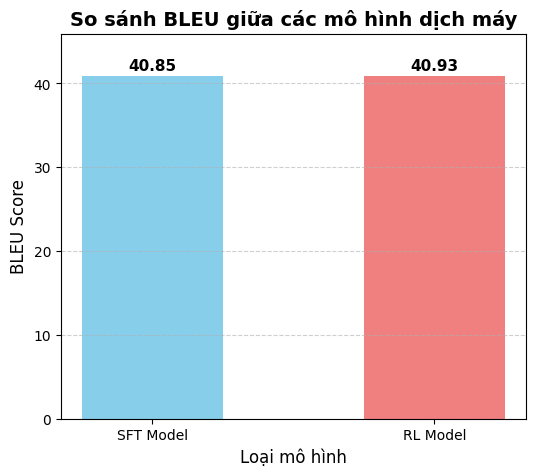

In [24]:
import matplotlib.pyplot as plt
bleu_sft = bleu_sft     # BLEU model SFT
bleu_rl = bleu_rl       # BLEU model RL

# Danh sách mô hình và BLEU tương ứng
models = ['SFT Model', 'RL Model']
bleu_scores = [bleu_sft, bleu_rl]

# ============================================================
# VẼ BIỂU ĐỒ CỘT
# ============================================================
plt.figure(figsize=(6, 5))
bars = plt.bar(models, bleu_scores, color=['skyblue', 'lightcoral'], width=0.5)

# Ghi giá trị BLEU lên đầu mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f"{yval:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Thêm tiêu đề và trục
plt.title("So sánh BLEU giữa các mô hình dịch máy", fontsize=14, fontweight='bold')
plt.ylabel("BLEU Score", fontsize=12)
plt.xlabel("Loại mô hình", fontsize=12)
plt.ylim(0, max(bleu_scores) + 5)

# Hiển thị
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [43]:
from sacrebleu.metrics import BLEU

bleu_metric = BLEU(effective_order=True)
better_examples = []
n = len(trans_sft)
for i in range(n):
    ref = test_ds[i]["Vietnamese"]
    sft_pred = trans_sft[i]
    dpo_pred = trans_rl[i]

    bleu_sft = bleu_metric.sentence_score(sft_pred, [ref]).score
    bleu_dpo = bleu_metric.sentence_score(dpo_pred, [ref]).score

    if bleu_dpo > bleu_sft:
        better_examples.append({
            "index": i,
            "diff": bleu_dpo - bleu_sft,
            "EN": test_ds[i]["English"],
            "REF": ref,
            "SFT": sft_pred,
            "SFT_BLEU": bleu_sft,
            "DPO": dpo_pred,
            "DPO_BLEU": bleu_dpo
        })
better_examples = sorted(better_examples, key=lambda x: x['diff'], reverse=True)

In [48]:
for ex in better_examples[:15]:
    print(f"\n")
    print(f"EN : {ex['EN']}")
    print(f"REF: {ex['REF']}")
    print(f"SFT: {ex['SFT']}")
    print(f"DPO: {ex['DPO']}")



EN : It is hard to convince John.
REF: thật khó để thuyết phục john.
SFT: nó khó để đánh giá cao john.
DPO: rất khó để thuyết phục john.


EN : I brought Tom home
REF: tôi đã mang tom về nhà
SFT: tôi đã đưa tom về nhà
DPO: tôi đã mang tom về nhà


EN : He is certain to come.
REF: anh ấy chắc chắn sẽ đến
SFT: anh ấy chắc chắn đến.
DPO: anh ấy chắc chắn sẽ đến.


EN : In the same amount of time it would take me to correct all the mistakes in your report, I could write a better report myself
REF: trong cùng một khoảng thời gian tôi sẽ phải sửa tất cả các lỗi trong báo cáo của bạn, tôi có thể tự viết một báo cáo tốt hơn
SFT: Tôi sẽ dành cho tôi một báo cáo tốt hơn, tôi có thể viết một báo cáo tốt hơn
DPO: Trong một khoảng thời gian đó, tôi có thể viết một số sai lầm trong báo cáo của bạn, tôi có thể viết một báo cáo tốt hơn


EN : How many people in this room do you think know Tom's last name?
REF: bạn nghĩ có bao nhiêu người trong căn phòng này biết họ của tom?
SFT: bạn nghĩ bạn biết tê